# Data Science
# Exercise 3 - Clustering
<br/>Student:
<br/>se21m024
<br/>Thomas Stummer
<br/><br/>The interpretation of the data can be found in the document <b><i>se21m024_Stummer_ex3_Clustering.pdf</i><b>.
<br/><br/>

# Import necessary dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import numpy as np
import seaborn as sns
import math as math
import itertools as it
from sklearn.manifold import MDS
import sklearn.datasets as dt
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
from sklearn.preprocessing import OneHotEncoder

pd.options.display.max_columns = None

%matplotlib inline

# Provide Calculation and Plot Function

In [2]:
def plot_data (X, attr_x, attr_y, algorithm, name):
    
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    algorithm.fit(X)
    
    if hasattr(algorithm, "labels_"):
        y_pred = algorithm.labels_.astype(int)
    else:
        y_pred = algorithm.predict(X)

    colors = np.array(
        list(
            islice(
                cycle(
                    [
                        "#377eb8",
                        "#ff7f00",
                        "#4daf4a",
                        "#f781bf",
                        "#a65628",
                        "#984ea3",
                        "#999999",
                        "#e41a1c",
                        "#dede00",
                    ]
                ),
                int(max(y_pred) + 1),
            )
        )
    )
    # add red color for outliers (if any)
    colors = np.append(colors, ["#ff0000"])

    fig = plt.figure(2, (10,7))
    plt.scatter(X[:, attr_x], X[:, attr_y], s=10, color=colors[y_pred])
    plt.title(name)
    plt.xlabel("Coordinate 1")
    plt.ylabel("Coordinate 2")
    plt.show()

# Toy Data Set

Data taken from:
<br/>https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html
<br/><br/>

## Import Data

In [5]:
np.random.seed(0)
n_samples = 1500
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

X, y = varied

## Algorithm 1: MiniBatch KMeans


C:\Users\thomas.stummer\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


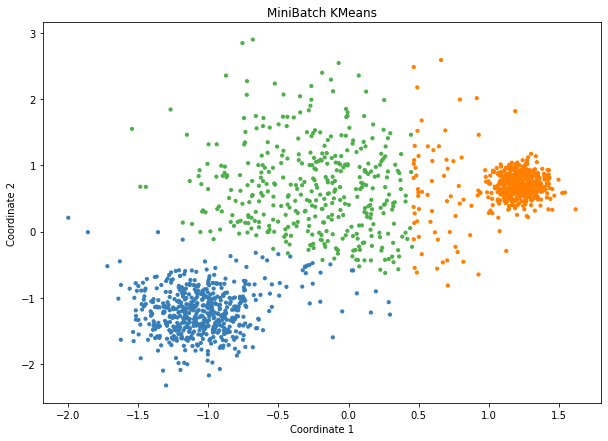

In [116]:
algorithm = cluster.MiniBatchKMeans(n_clusters=3, random_state=random_state)

plot_data(X, 0, 1, algorithm, "MiniBatch KMeans")

## Algorithm 2: Agglomerative Clustering


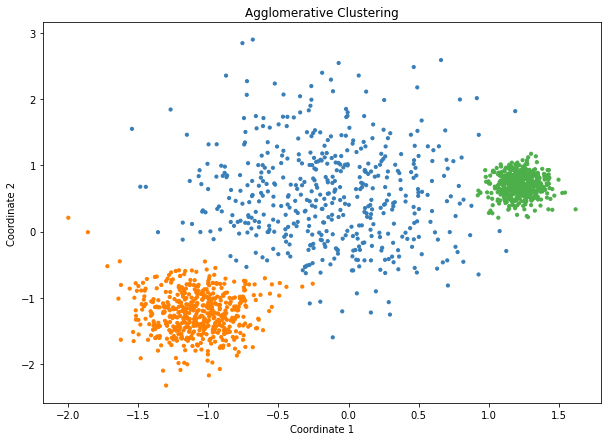

In [118]:
# connectivity matrix for structured Ward
connectivity = kneighbors_graph(
    X, n_neighbors=10, include_self=False
)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

algorithm = cluster.AgglomerativeClustering(
    linkage="ward",
    affinity="euclidean",
    n_clusters=3,
    connectivity=connectivity    
)

plot_data(X, 0, 1, algorithm, "Agglomerative Clustering")

## Algorithm 3: DBSCAN


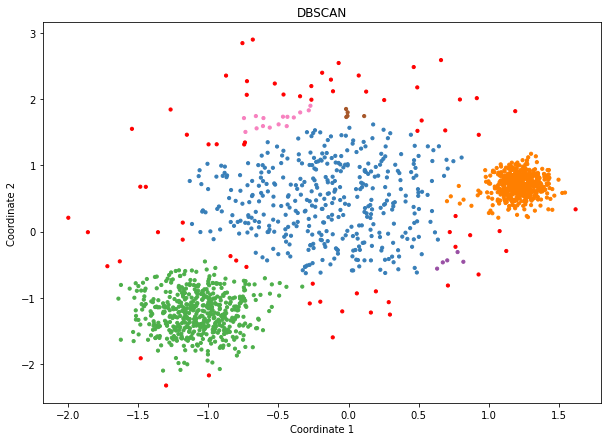

In [125]:
algorithm = cluster.DBSCAN(eps=0.16)

plot_data(X, 0, 1, algorithm, "DBSCAN")

# Small Data Set: Heart Disease

Data taken from:
<br/>https://archive.ics.uci.edu/ml/datasets/Heart+Disease
<br/><br/>
Data Creators:
1. Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D.
2. University Hospital, Zurich, Switzerland: William Steinbrunn, M.D.
3. University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
4. V.A. MediMcal Center, Long Beach and Cleveland Clinic Foundation: Robert Detrano, M.D., Ph.D.

## Import Data

In [293]:
# Only examine processed data with a subset of 14 attributes
columns = [
    'Age', 'Sex', 'Chest Pain Type', 'Resting Blood Pressure', 'Serum Cholestoral', 
    'Increased Blood Sugar', 'Electrocardiographic', 'Peak Heart Rate', 'Angina', 
    'ST depression', 'Peak Exercise ST Segment', 'Major Vessels', 'Thal', 'Diagnosis']

cleveland_raw_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data', sep=',', names = columns, skipinitialspace=True)
hungarian_raw_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data', sep=',', names = columns, skipinitialspace=True)
switzerland_raw_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data', sep=',', names = columns, skipinitialspace=True)
va_raw_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data', sep=',', names = columns, skipinitialspace=True)

raw_data = pd.concat([cleveland_raw_data, hungarian_raw_data, switzerland_raw_data, va_raw_data])

# re-shuffle records just to randomize data points
raw_data = raw_data.sample(frac=1, random_state=42).reset_index(drop=True)

data=raw_data

### Helper functions

def roundElementToIntSafe(y):
    try:
        return int(float(y))
    except:
        return None

def roundToInt(x):
    return x.apply(lambda value: roundElementToIntSafe(value))

def parseFloatElementSafe(y):
    try:
        return float(y)
    except:
        return None

def parseFloat(x):
    return x.apply(lambda value: parseFloatElementSafe(value)) 


### Parse columns, assign categories, remove invalid records

numericalColumns = []
categoryColumns = []
numericalCategoryColumns = []

def processColumn(data, column, isFloat=False, categoryMapping=None, categories=None):

    # Parse
    if not isFloat:
        data[column] = roundToInt(data[column])
    else:
        data[column] = parseFloat(data[column])

    # (optional) Filter records that contain one or more invalid columns
    data = data.drop(data[data[column].isnull()].index)

    # Append to global array
    if categoryMapping is None:
        numericalColumns.append(column)
    else:
        numericalCategoryColumns.append(column)
        categoryColumn = column
        categoryColumns.append(categoryColumn)
        data[categoryColumn] = data[column].apply(categoryMapping)
    	
        # (optional) Filter records that contain one or more invalid columns
        data = data.drop(data[data[categoryColumn].isnull()].index)

        # Add category
        data[categoryColumn] = pd.Categorical(data[categoryColumn], categories=categories)

    return data

# Age
processColumn(data=data, column='Age')

# Sex
data = processColumn(data=data, column='Sex',
categoryMapping=(lambda value: 'male' if value == 1 else 'female' if value == 0 else None), 
categories=['male', 'female'])

# Chest Pain Type
data = processColumn(data=data, column='Chest Pain Type',
categoryMapping=(lambda value: 'typical angina' if value == 1 else 'atypical angina' if value == 2 else 'non-anginal pain' if value == 3 else 'asymptomatic' if value == 4 else None), 
categories=['typical angina', 'atypical angina', 'non-anginal pain', 'asymptomatic'])

#  Resting Blood Pressure [mm Hg] (in mm Hg on admission to the hospital) 
data = processColumn(data=data, column='Resting Blood Pressure')

# Serum Cholestoral in mg/dl 
data = processColumn(data=data, column='Serum Cholestoral')
# Fix Serum Cholestoral = 0
data['Serum Cholestoral'] = data['Serum Cholestoral'].apply(lambda value: value if value > 0 else None)

# Fasting Blood Sugar > 120 mg/dl
data = processColumn(data=data, column='Increased Blood Sugar',
categoryMapping=(lambda value: 'True' if value == 1 else 'False' if value == 0 else None), 
categories=['True', 'False'])

# Resting Electrocardiographic Results
data = processColumn(data=data, column='Electrocardiographic',
categoryMapping=(lambda value: 'normal' if value == 0 else 'abnormality' if value == 1 else 'hypertrophy' if value == 2 else None),
categories=['normal', 'abnormality', 'hypertrophy'])

# Maximum Heart Rate achieved 
data = processColumn(data=data, column='Peak Heart Rate')

# Exercise induced Angina
data = processColumn(data=data, column='Angina',
categoryMapping=(lambda value: 'Yes' if value == 1 else 'No' if value == 0 else None),
categories=['Yes', 'No'])

# ST depression induced by exercise relative to rest 
data = processColumn(data=data, column='ST depression', isFloat=True)

# Slope of the peak exercise ST segment
data = processColumn(data=data, column='Peak Exercise ST Segment',
categoryMapping=(lambda value: 'upsloping' if value == 1 else 'flat' if value == 2 else 'downsloping' if value == 3 else None), 
categories=['upsloping', 'flat', 'downsloping'])

# Number of major vessels (0-3) colored by flourosopy
data = processColumn(data=data, column='Major Vessels')

# Thal
data = processColumn(data=data, column='Thal',
categoryMapping=(lambda value: 'normal' if value == 3 else 'fixed defect' if value == 6 else 'reversable defect' if value == 7 else None),
categories=['normal', 'fixed defect', 'reversable defect'])

# Diagnosis of heart disease (angiographic disease status)
data = processColumn(data=data, column='Diagnosis',
categoryMapping=(lambda value: '< 50% diameter narrowing' if value == 0 else '> 50% diameter narrowing' if value == 1 else None), 
categories=['< 50% diameter narrowing', '> 50% diameter narrowing'])

# Convert to categories
for column in categoryColumns:
    data[column] = pd.factorize(data[column])[0] + 1

#data.head(5)

def parseFloatElementSafe(y):
    try:
        return float(y)
    except:
        return None

def parseFloat(x):
    return x.apply(lambda value: parseFloatElementSafe(value)) 

data = data.apply(parseFloat) 
data = data.dropna()

# One hot encoding for categorical columns
enc = OneHotEncoder(handle_unknown='ignore')
encoded_data = pd.get_dummies(data, columns=categoryColumns, prefix_sep='_', drop_first=False)

X = encoded_data.to_numpy()

## Algorithm 1: MiniBatch KMeans

C:\Users\thomas.stummer\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


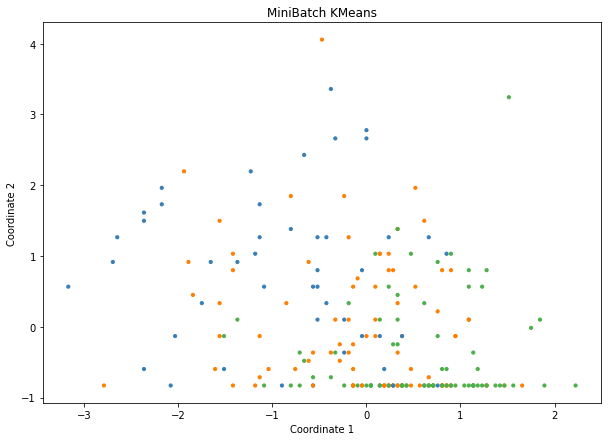

In [300]:
algorithm = cluster.MiniBatchKMeans(n_clusters=3, random_state=random_state)

plot_data(X, 3, 4, algorithm, "MiniBatch KMeans")

## Algorithm 2: Agglomerative Clustering

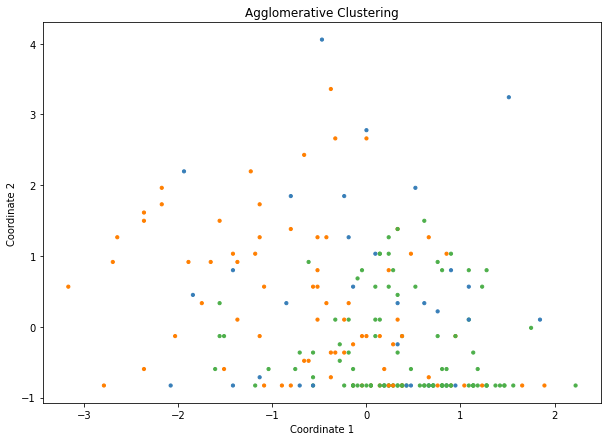

In [301]:
# connectivity matrix for structured Ward
connectivity = kneighbors_graph(
    X, n_neighbors=10, include_self=False
)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

algorithm = cluster.AgglomerativeClustering(
    linkage="ward",
    affinity="euclidean",
    n_clusters=3,
    connectivity=connectivity    
)

plot_data(X, 3, 4, algorithm, "Agglomerative Clustering")

## Algorithm 3: DBSCAN

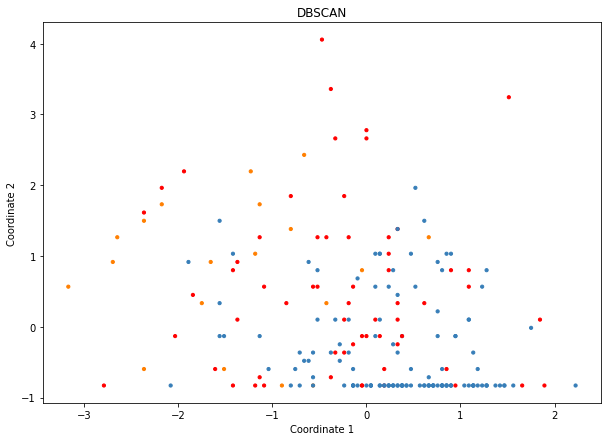

In [315]:
algorithm = cluster.DBSCAN(eps=9.0, min_samples=5, metric="cityblock")

plot_data(X, 3, 4, algorithm, "DBSCAN")

# Big Data Set: Census Income

Data taken from:
<br/>https://archive.ics.uci.edu/ml/datasets/Census-Income+%28KDD%29
<br/><br/>
Data Original Owner:
<br/>U.S. Census Bureau
<br/>http://www.census.gov/
<br/>United States Department of Commerce
<br/><br/>
Donor:
<br/>Terran Lane and Ronny Kohavi
<br/>Data Mining and Visualization
<br/>Silicon Graphics.
<br/>terran '@' ecn.purdue.edu, ronnyk '@' sgi.com

## Import Data

In [7]:
columns = ['age', 'class of worker', 'detailed industry recode', 'detailed occupation recode', 'education', 'wage per hour', 
'enroll in edu inst last wk', 'marital stat', 'major industry code', 'major occupation code', 'race', 
'hispanic origin', 'sex', 'member', 'reason for unemployment', 'full or part time employment stat', 
'capital gains', 'capital losses', 'dividends from stocks', 'tax filer stat', 'region of previous residence', 
'state of previous residence', 'detailed household and family stat', 'detailed household summary in household',  
'instance weight', 'migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg', 
'live in this house 1 year ago', 'migration prev res in sunbelt', 'num persons worked for employer', 'family members under 18', 
'country of birth father', 'country of birth mother', 'country of birth self', 'citizenship', 'own business or self employed', 
'fill inc questionnaire for veterans admin', 'veterans benefits', 'weeks worked in year', 'year', '???']

raw_data = pd.read_csv('../Data Sets/Census-Income/census-income.data', sep=',', names = columns, skipinitialspace=True)

# re-shuffle records just to randomize data points
raw_data = raw_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Examine only a subset of all attributes
numericalColumns = ['age', 'wage per hour', ]

categoryColumns = [
    'class of worker', 
    'education', 
    'race', 
    'hispanic origin', 
    'sex', 
    'year'
]

subset_attributes = numericalColumns + categoryColumns

# Assumption: The wage per hour is reprecented in Dollar Cents. For clearer interpretation it is converted to Dollars.
#print("Assumption: The wage per hour is reprecented in Dollar Cents. For clearer interpretation it is converted to Dollars.")
raw_data['wage per hour'] = raw_data['wage per hour'].apply(lambda value: value / 100)

# Fix wage per hour = 0
raw_data['wage per hour'] = raw_data['wage per hour'].apply(lambda value: None if value == 0 else value)

# Convert to categories
for column in categoryColumns:
    raw_data[column] = pd.factorize(raw_data[column])[0] + 1

data=raw_data[subset_attributes]
#print(data.head(5))

def parseFloatElementSafe(y):
    try:
        return float(y)
    except:
        return None

def parseFloat(x):
    return x.apply(lambda value: parseFloatElementSafe(value)) 

data = data.apply(parseFloat) 
data = data.dropna()

# One hot encoding for categorical columns
enc = OneHotEncoder(handle_unknown='ignore')
encoded_data = pd.get_dummies(data, columns=categoryColumns, prefix_sep='_', drop_first=False)

X = encoded_data.to_numpy()


## Algorithm 1: MiniBatch KMeans

C:\Users\thomas.stummer\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


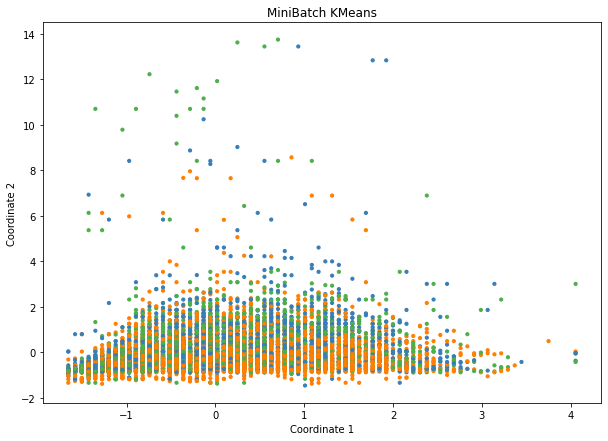

In [20]:
from sklearn.metrics import silhouette_score


algorithm = cluster.MiniBatchKMeans(n_clusters=3, random_state=random_state)

#silhouette_KMeans = silhouette_score(X, algorithm., metric='euclidean')

plot_data(X, 0, 1, algorithm, "MiniBatch KMeans")

## Algorithm 2: Agglomerative Clustering

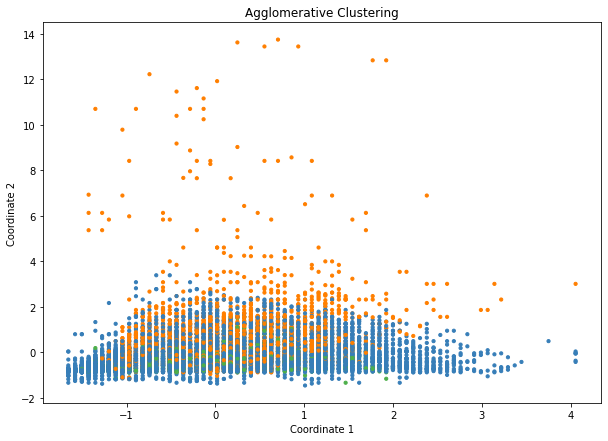

In [23]:
# connectivity matrix for structured Ward
connectivity = kneighbors_graph(
    X, n_neighbors=10, include_self=False
)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

algorithm = cluster.AgglomerativeClustering(
    linkage="ward",
    affinity="euclidean",
    n_clusters=3,
    connectivity=connectivity    
)

plot_data(X, 0, 1, algorithm, "Agglomerative Clustering")

## Algorithm 3: DBSCAN

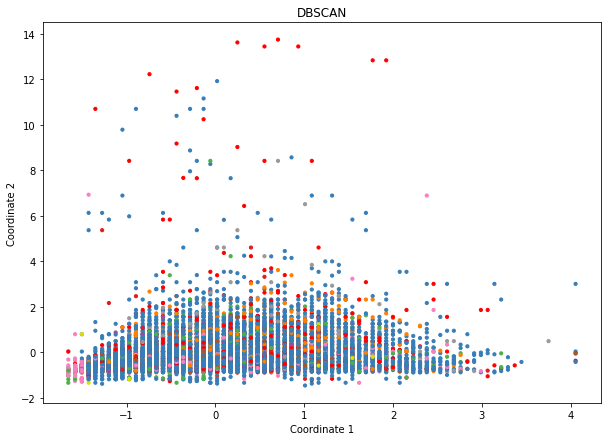

In [19]:
algorithm = cluster.DBSCAN(eps=7.0, min_samples=20, metric="cityblock")

plot_data(X, 0, 1, algorithm, "DBSCAN")

## Quantitative Algorithm Comparison

### Overall Similarity
(the higher, the better)

### Silhouette
* Most objects high value: clustering configuration is appropriate
* Many points a low / negative value: too many or too few clusters